using conda env `ai`

# Watch for downloads and downsample

MemoryError: 

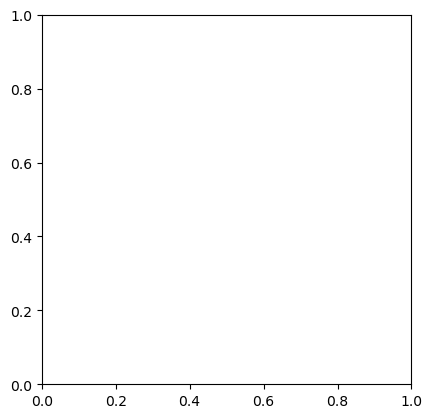

In [3]:
import shutil
import os
import zipfile
import time
import json
import matplotlib.pyplot as plt

os.add_dll_directory('C://openslide-win64/bin')

import openslide

# open the slide
slide = openslide.OpenSlide('C:\\Users\\Kontor\\Github Repos\\Notebooks\\biomedical\\test.ndpi')
# show
region = slide.read_region((0, 0), 0, slide.level_dimensions[0])

# display the region using matplotlib
plt.imshow(region)
plt.show()

In [10]:
import shutil
import os
import zipfile
import time
import json

os.add_dll_directory('C://openslide-win64/bin')

import openslide

def save_image(ndpi_file_path, magnification_level, output_file, processed_path):
	ndpi_file = openslide.OpenSlide(ndpi_file_path)

	# Get the dimensions of the NDPI image
	ndpi_width, ndpi_height = ndpi_file.dimensions

	# Get the metadata from the NDPI file
	metadata = dict(ndpi_file.properties)

	# Get width and height from metadata
	ndpi_width = int(metadata['openslide.level[4].width'])
	ndpi_height = int(metadata['openslide.level[4].height'])

	# Load the image at the specified magnification level
	ndpi_image = ndpi_file.read_region((0, 0), magnification_level, (ndpi_width, ndpi_height))

	# Convert the image to RGB format
	ndpi_image = ndpi_image.convert('RGB')

	# Save the image
	ndpi_image.save(output_file)

    # Save the metadata as a JSON file
	metadata_path = os.path.join(processed_path, 'metadata')
	metadata = dict(ndpi_file.properties)
	if not os.path.exists(metadata_path):
		os.mkdir(metadata_path)
	with open(os.path.join(os.path.join(processed_path, 'metadata'), ndpi_file_path[:-5] + '.json'), 'w') as metadata_file:
		json.dump(metadata, metadata_file)

def log_status(status):
    with open("log.txt", "a") as log_file:
        log_file.write(status + "\n")

save_image("test.ndpi", 4, "test.jpg", ".")


In [ ]:
while True:
  for file in os.listdir("data"):
    if file.endswith(".zip"):
      print('Extracting', file)
      # Create a ZipFile Object and load sample.zip in it

      folder_path = "data\\{}".format(file[:-4])
      processed_path = "processed\\{}".format(file[:-4])

      with zipfile.ZipFile("data\\{}".format(file), 'r') as zip_ref:
        # Extract the contents to the new folder
        zip_ref.extractall(folder_path)
    
      # Remove the zip file
      os.remove("data\\{}".format(file))


      if not os.path.exists(processed_path):
        os.makedirs(processed_path)
        os.makedirs(os.path.join(processed_path, 'metadata'))

      for file in os.listdir(folder_path):
        if file.endswith('.ndpi'):
          print('Saving', file)
          try:
            save_image(os.path.join(folder_path, file), 4, os.path.join(processed_path, file[:-5] + '.png'))
          except:
            print('Error saving', file)
      
      print('Cleaning up')
      # Remove the folder
      shutil.rmtree(folder_path)
  time.sleep(2)

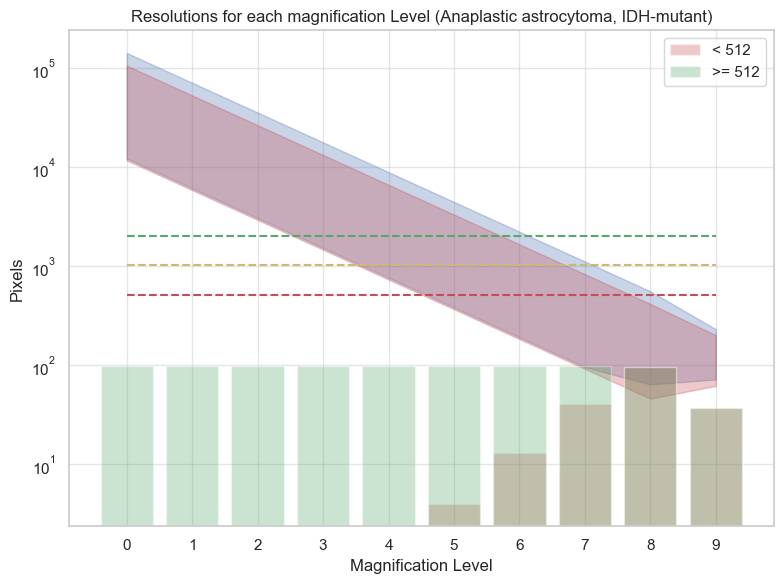

Level 0 Min: 12288x11776
Level 1 Min: 6144x5888
Level 2 Min: 3072x2944
Level 3 Min: 1536x1472
Level 4 Min: 768x736
Level 5 Min: 384x368
Level 6 Min: 192x184
Level 7 Min: 96x92
Level 8 Min: 64x46
Level 9 Min: 72x62
Level 0 Max: 143360x106752
Level 1 Max: 71680x53376
Level 2 Max: 35840x26688
Level 3 Max: 17920x13344
Level 4 Max: 8960x6672
Level 5 Max: 4480x3336
Level 6 Max: 2240x1668
Level 7 Max: 1120x834
Level 8 Max: 560x417
Level 9 Max: 232x202


In [111]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

processed_path = "processed"

folders = [folder for folder in os.listdir(processed_path) if os.path.isdir(os.path.join(processed_path, folder))]

# Initialize lists for storing width and height data
min_widths = [np.inf] * 10
max_widths = [-np.inf] * 10
min_heights = [np.inf] * 10
max_heights = [-np.inf] * 10

num_below_threshold = [0] * 10
num_above_threshold = [0] * 10
threshold = 512

for folder in folders:

  metadata_path = os.path.join(processed_path, folder, "metadata")
  
  if os.path.exists(metadata_path):
    for file in os.listdir(metadata_path):
      if file.endswith(".json"):
        with open(os.path.join(metadata_path, file), "r") as metadata_file:
          metadata = json.load(metadata_file)
          
          for level in range(10):
            width_key = f"openslide.level[{level}].width"
            height_key = f"openslide.level[{level}].height"

            if width_key in metadata and height_key in metadata:
              width = int(metadata[width_key])
              height = int(metadata[height_key])

              min_widths[level] = min(min_widths[level], width)
              max_widths[level] = max(max_widths[level], width)
              min_heights[level] = min(min_heights[level], height)
              max_heights[level] = max(max_heights[level], height)

              if width < threshold or height < threshold:
                num_below_threshold[level] += 1
              num_above_threshold[level] += 1

# Create the plot
fig, ax = plt.subplots(figsize=(8,6))
x = np.arange(10)

# Plot min and max widths
ax.fill_between(x, min_widths, max_widths, alpha=0.3, color='b')

# Plot min and max heights
ax.fill_between(x, min_heights, max_heights, alpha=0.3, color='r')

plt.bar(x, num_below_threshold, alpha=0.3, color='r', label='< {}'.format(threshold))
plt.bar(x, num_above_threshold, alpha=0.3, color='g', label='>= {}'.format(threshold))

ax.set_xlabel('Magnification Level')
ax.set_ylabel('Pixels')
ax.set_title('Resolutions for each magnification Level ({})'.format(folder))
ax.legend()

ax.hlines(512, 0, 9, colors='r', linestyles='dashed')
ax.hlines(1024, 0, 9, colors='y', linestyles='dashed')
ax.hlines(2048, 0, 9, colors='g', linestyles='dashed')

ax.set_xticks(x)

ax.set_yscale('log')

fig.tight_layout()
plt.grid(alpha=0.5)
plt.show()


for level in range(10):
  print(f"Level {level} Min: {min_widths[level]}x{min_heights[level]}")
for level in range(10):
  print(f"Level {level} Max: {max_widths[level]}x{max_heights[level]}")

# Visualize metadata

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Read the CSV file
data_file = 'annotation.csv'
df = pd.read_csv(data_file)

Number of patients: 3115
Number of tumor types: 127
Number of tumor grades: 5
Number of tumor subtypes: 42
Number of control samples: 47
Number of recurrences: 433
Average age: 45.62 (standard deviation: 22.22)
Sex distribution:
male      1593
female    1496
Name: sex, dtype: int64


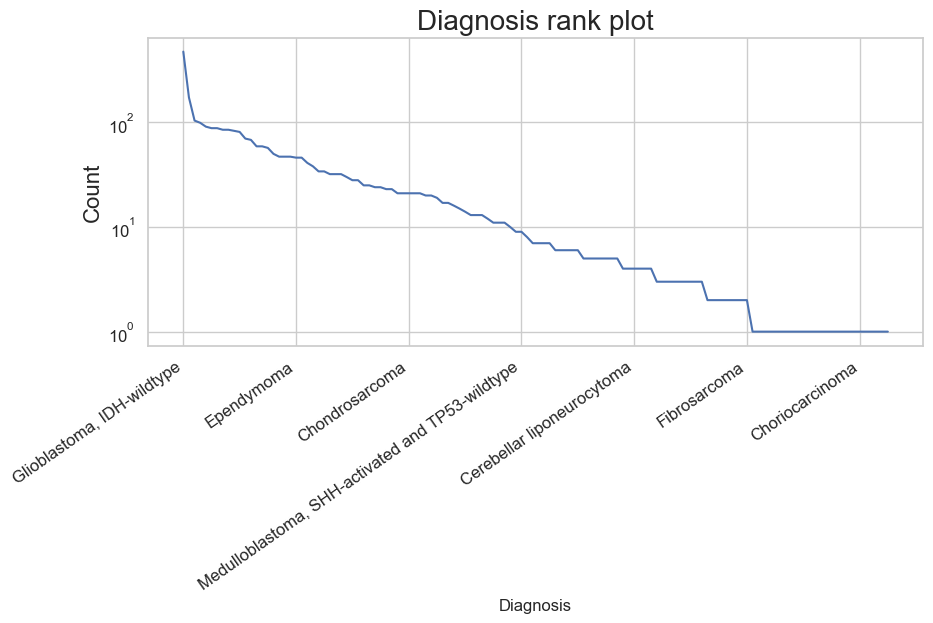

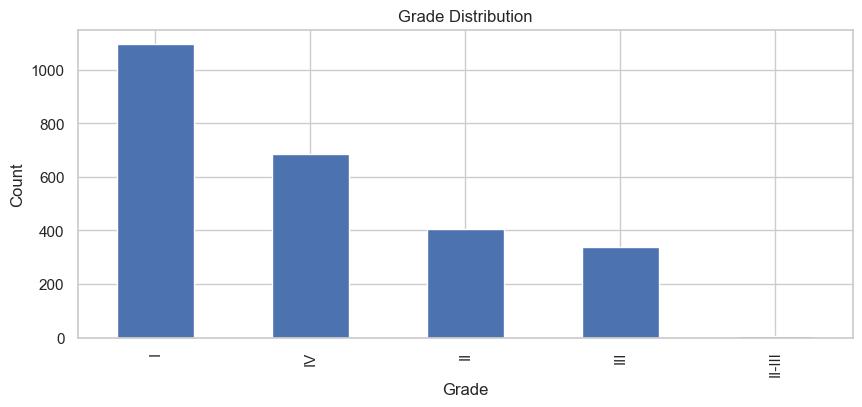

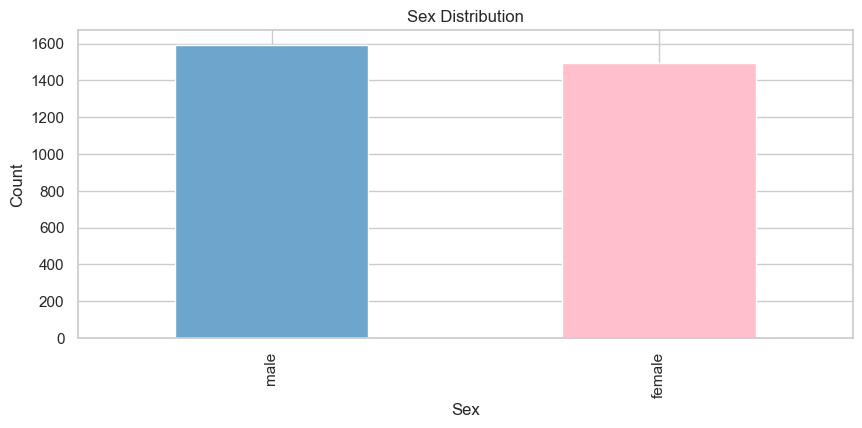

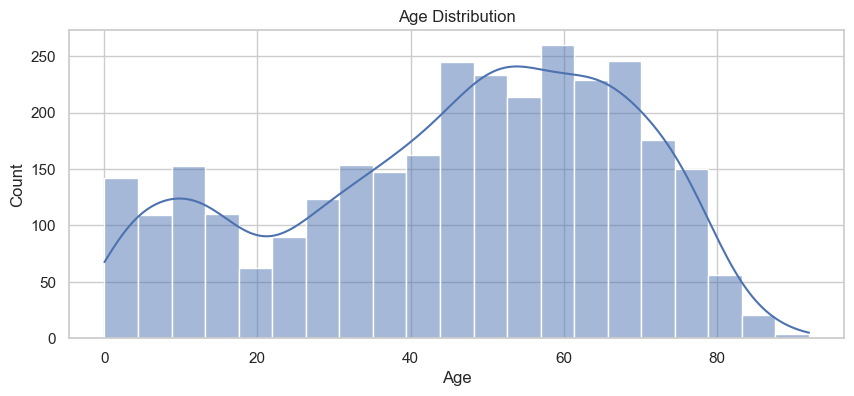

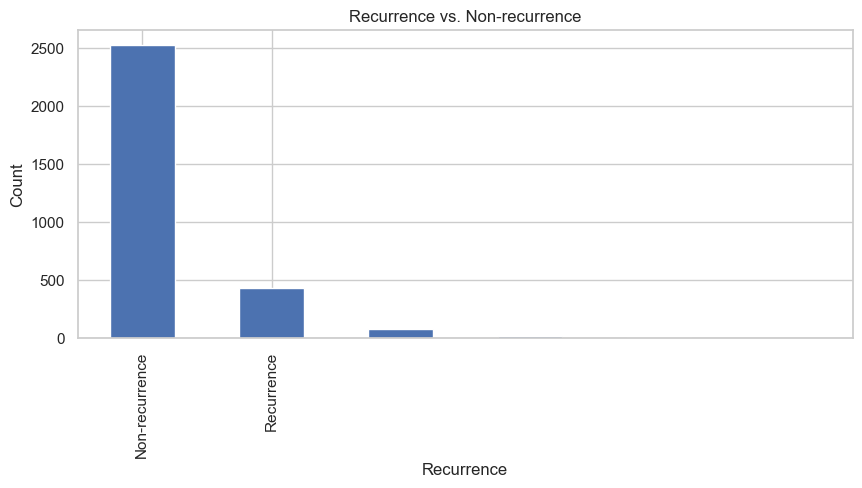

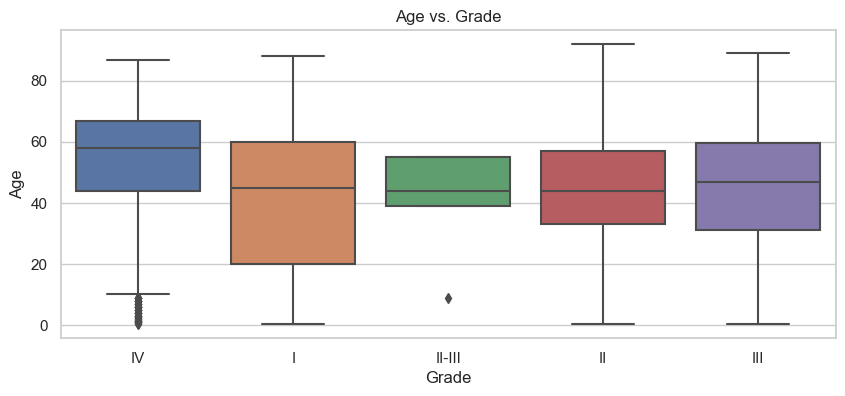

In [2]:
# Basic analysis
num_patients = len(df)
num_tumor_types = len(df['diagnosis'].unique())
num_grades = len(df['grade'].dropna().unique())
num_subtypes = len(df['subtype'].dropna().unique())
num_controls = len(df[df['control'] == 1])
num_recurrences = len(df[df['recurrence'] == 1])
age_mean = df['age'].mean()
age_std = df['age'].std()
sex_counts = df['sex'].value_counts()

# Print results
print(f'Number of patients: {num_patients}')
print(f'Number of tumor types: {num_tumor_types}')
print(f'Number of tumor grades: {num_grades}')
print(f'Number of tumor subtypes: {num_subtypes}')
print(f'Number of control samples: {num_controls}')
print(f'Number of recurrences: {num_recurrences}')
print(f'Average age: {age_mean:.2f} (standard deviation: {age_std:.2f})')
print('Sex distribution:')
print(sex_counts)

# Set plotting style
sns.set(style="whitegrid")

# Diagnosis rank plot
plt.figure(figsize=(10, 4))
diagnosis_counts = df['diagnosis'].value_counts()
diagnosis_top = diagnosis_counts.head(128)
diagnosis_top.plot(kind='line')
plt.title('Diagnosis rank plot', fontsize=20)
plt.xlabel('Diagnosis')
plt.ylabel('Count', fontsize=16)
plt.xticks(rotation=35, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')
plt.show()
# Grade distribution
plt.figure(figsize=(10, 4))
grade_counts = df['grade'].value_counts()
grade_counts.plot(kind='bar')
plt.title('Grade Distribution')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.show()

# Sex distribution
plt.figure(figsize=(10, 4))
sex_counts = df['sex'].value_counts()
sex_counts.plot(kind='bar', color=['#6CA6CD', '#FFC0CB'])
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()


# Age distribution
plt.figure(figsize=(10, 4))
sns.histplot(df['age'].dropna(), kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Recurrence vs. Non-recurrence
plt.figure(figsize=(10, 4))
recurrence_counts = df['recurrence'].value_counts()
recurrence_counts.plot(kind='bar')
plt.title('Recurrence vs. Non-recurrence')
plt.xlabel('Recurrence')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-recurrence', 'Recurrence'])
plt.show()

# Age vs. Grade boxplot
plt.figure(figsize=(10, 4))
sns.boxplot(x='grade', y='age', data=df)
plt.title('Age vs. Grade')
plt.xlabel('Grade')
plt.ylabel('Age')
plt.show()

# Training model

First define the *ImageFolderData* class.

In [171]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from PIL import Image
import os

class ImageFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        for i, class_dir in enumerate(os.listdir(root_dir)):
            class_path = os.path.join(root_dir, class_dir)
            if not os.path.isdir(class_path):
                continue
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                if not image_path.endswith('.jpg') and not image_path.endswith('.png'):
                    continue
                self.image_paths.append(image_path)
                self.labels.append(i)
        self.classes = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        with open(image_path, 'rb') as f:
            image = Image.open(f)
            image = image.convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


Next load the data.

In [187]:
root_dir = 'processed'
# same normalization as ImageNet
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
dataset = ImageFolderDataset(root_dir=root_dir, transform=transform)
# Shuffle the indices of the dataset
indices = list(range(len(dataset)))
np.random.shuffle(indices)
dataset = torch.utils.data.Subset(dataset, indices)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# plot first 
import matplotlib.pyplot as plt

plot_images = False
if plot_images:
    fig, axes = plt.subplots(3, 6, figsize=(18, 9))
    for i, ax in enumerate(axes.flat):
        image, label = train_dataset[i]
        image = image * torch.tensor(std).view(3,1,1) + torch.tensor(mean).view(3,1,1)  # unnormalize
        image = torch.clamp(image, 0, 1)  # clamp pixel values to range [0, 1]
        ax.imshow(image.permute(1, 2, 0)) # display the image
        ax.set_axis_off()
        ax.set_title(label)

Define and train the model

In [242]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms


# Define the CNN model
class TumorClassifier(nn.Module):
  def __init__(self):
    super(TumorClassifier, self).__init__()
    self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(16 * 128 * 128, 512)
    self.fc2 = nn.Linear(512, 2)

  def forward(self, x):
    x = nn.functional.relu(self.conv1(x))
    #print('Shape after first conv+relu:', x.shape)
    x = self.pool(nn.functional.relu(self.conv2(x)))
    #print('Shape after second conv+relu+pool:', x.shape)
    x = self.pool(nn.functional.relu(self.conv3(x)))
    #print('Shape after third conv+relu+pool:', x.shape)
    x = x.view(8, -1)
    #print('Shape after flattening:', x.shape)
    x = nn.functional.relu(self.fc1(x))
    #print('Shape after first fc+relu:', x.shape)
    x = self.fc2(x)
    #print('Shape after second fc:', x.shape)
    return x

# Create an instance of the model and define the loss function and optimizer
model = TumorClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
print('Starting training...')
for epoch in range(num_epochs):
  running_loss = 0.0
  for i, (inputs, labels) in enumerate(train_loader):
    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward + backward + optimize
    outputs = model(inputs)
    print(outputs.shape, labels.shape)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # Print statistics
    running_loss += loss.item()
    print(loss.item())
    if i % 10 == 9:
      print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
      running_loss = 0.0

# Evaluate the model on the validation set
correct = 0
total = 0
with torch.no_grad():
  for inputs, labels in val_loader:
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy on the validation set: %d %%' % (100 * correct / total))

Starting training...


KeyboardInterrupt: 

Validate the model

In [247]:
model = TumorClassifier()
state_dict = torch.load('model.pth', map_location=torch.device('cpu'))

model.load_state_dict(state_dict)

model.eval()

# Evaluate the model on the validation set
correct = 0
total = 0
with torch.no_grad():
  for inputs, labels in val_loader:
    if(inputs.shape[0] != 8):
      continue
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy on the validation set: %d %%' % (100 * correct / total))

Accuracy on the validation set: 75 %


Plot training loss

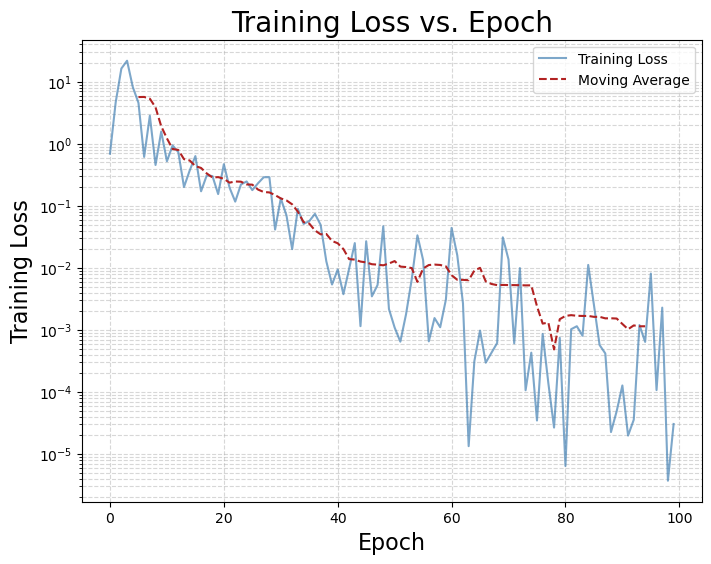

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load file
losses = []
with open('losses.txt', 'r') as f:
    for line in f.readlines():
      try:
        losses.append(float(line))
      except:
        pass


# Define moving average function
def moving_average(x, w):
  return np.convolve(x, np.ones(w), 'valid') / w

# Convert list of lists to NumPy array
numbers = np.array(losses)

w = 11
mov_avg = moving_average(losses, w)
avg_x = np.arange(int(w/2), len(losses) - int(w/2))

# Plot losses
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(losses, alpha=0.7, label='Training Loss', color='steelblue')
ax.plot(avg_x, mov_avg, '--', label='Moving Average', color='firebrick')
ax.set_yscale('log')
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('Training Loss', fontsize=16)
ax.set_title('Training Loss vs. Epoch', fontsize=20)
ax.grid(True, which='both', ls='--', alpha=0.5)
ax.legend()
plt.show()

In [238]:
# save losses.txt 
with open('losses.txt', 'w') as f:
	for item in losses:
		f.write("%s\n" % item)